In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import time
from alive_progress import alive_bar

from global_search_recommendation.BioInspiredRecomendation import BioInspiredRecomendation
from global_search_recommendation.dominio import Dominio
from percentile_recommendation.current_calculator import RecommendationCalculator
from SheetsConversor import SheetsConversor
from Complete import CompleteCalculator
from commons.Tariff import BlueTariff, GreenTariff

In [7]:
conversor = SheetsConversor('../sheets-plus/')
ucs, mods, contract = conversor.convert()

Reading ../sheets-plus/UFPR.xlsx...
Reading ../sheets-plus/UFMG_II.xlsx...
Reading ../sheets-plus/UFRA.xlsx...
Reading ../sheets-plus/UFMG_I.xlsx...
Reading ../sheets-plus/UFFS.xlsx...
Reading ../sheets-plus/UFAL.xlsx...
Reading ../sheets-plus/UFSJ.xlsx...
Reading ../sheets-plus/UFCA.xlsx...
Reading ../sheets-plus/UFJF.xlsx...
Reading ../sheets-plus/UFOP.xlsx...
Reading ../sheets-plus/UFMS.xlsx...
Reading ../sheets-plus/UFRGS.xlsx...
Done! 130 UCs conveted!


In [8]:
RESULT_HEADERS = ['method', 'flag', 'peak', 'off_peak', 'unique', 'cost', 'num_months', 'time']

def do_calculations(n: int):

    results = {}

    with alive_bar(len(ucs), force_tty=True) as bar:
        for k in ucs:
            result_frame = pd.DataFrame(columns=RESULT_HEADERS)
    
            cm = RecommendationCalculator(ucs[k].head(n), mods[k], BlueTariff(), GreenTariff(), n)
            result_frame.loc[len(result_frame)] = cm.calculate()

            bio_inspired = BioInspiredRecomendation(n, pd.DataFrame(ucs[k]))
            result_frame.loc[len(result_frame)] = bio_inspired.do_PSO(iterative=True)
            result_frame.loc[len(result_frame)] = bio_inspired.do_GA(iterative=True)

            #complete_calculator = CompleteCalculator(n, ucs[k])
            #result_frame.loc[len(result_frame)] = complete_calculator.run()

            #result_frame.loc[len(result_frame)] = Dominio().get_current_value(mods[k], contract[k])
    
            results[k] = result_frame
            bar()
            
    return results
    

In [9]:
warnings.filterwarnings('ignore')

results_per_range = []
for n in range(6, 13):
    print(f"Calculating to {n} months...", flush=True)
    results_per_range.append(do_calculations(n))

Calculating to 6 months...
|████████████████████████████████████████| 130/130 [100%] in 50.7s (2.55/s)     
Calculating to 7 months...
|████████████████████████████████████████| 130/130 [100%] in 55.7s (2.33/s)     
Calculating to 8 months...
|████████████████████████████████████████| 130/130 [100%] in 58.0s (2.24/s)     
Calculating to 9 months...
|████████████████████████████████████████| 130/130 [100%] in 1:05.3 (1.99/s)    
Calculating to 10 months...
|████████████████████████████████████████| 130/130 [100%] in 1:05.8 (1.97/s)    
Calculating to 11 months...
|████████████████████████████████████████| 130/130 [100%] in 1:09.4 (1.87/s)    
Calculating to 12 months...
|████████████████████████████████████████| 130/130 [100%] in 1:15.1 (1.73/s)    


In [5]:
def get_methods_economy_percentage(results):
    costs = pd.DataFrame(columns=results['../sheets-plus/UFMS.xlsx - 109001794-8'].method)
    for r in results:
        result = results[r].drop(columns=['method', 'flag', 'peak', 'off_peak', 'unique', 'num_months', 'time'])
        costs.loc[len(costs)] = result.T.values[0]

    percentil_economy = round(((costs.Atual - costs.Percentil)/costs.Atual).sum()/len(results), 4) * 100
    pso_economy = round(((costs.Atual - costs['PSO-it'])/costs.Atual).sum()/len(results), 4) * 100
    ga_economy = round(((costs.Atual - costs['GA-it'])/costs.Atual).sum()/len(results), 4) * 100
    potential = round(((costs.Atual - costs['Completo'])/costs.Atual).sum()/len(results), 4) * 100

    return [percentil_economy, pso_economy, ga_economy, potential]

In [6]:
def get_methods_time_perf(results):
    headers = results['../sheets-plus/UFMS.xlsx - 109001794-8'].method[:4]
    times = pd.DataFrame(columns=headers)

    for r in results:
        result = results[r].drop(columns=['method', 'flag', 'peak', 'off_peak', 'unique', 'cost', 'num_months'])
        times.loc[len(times)] = result.T.values[0][:4]
    
    return [ {h:times[h].mean()} for h in headers ]

In [31]:
def get_demand_diference(results):
    flags = [0, 0, 0]  # percentil/pso, percentil/ga, pso/ga
    pso_dif, ga_dif = [0, 0, 0], [0, 0, 0]
    pso, ga = [0, 0], [0, 0]
    
    for r in results:
        # Drop unnecessary columns and transpose the result
        result = results[r].drop(columns=['method', 'cost', 'num_months', 'time'])
        t = result.T.values
        
        # PSO comparison
        if t[0][0] == t[0][1] and t[0][0] == 'Verde':
            pso_dif[2] += t[3][1] - t[3][0]
            pso[0] += 1
        elif t[0][0] == t[0][1] and t[0][0] == 'Azul':
            pso_dif[0] += t[1][1] - t[1][0]
            pso_dif[1] += t[2][1] - t[2][0]
            pso[1] += 1
        else:
            flags[0] += 1  # percentil/pso flag
        
        # GA comparison
        if t[0][0] == t[0][2] and t[0][0] == 'Verde':
            ga_dif[2] += t[3][2] - t[3][0]
            ga[0] += 1
        elif t[0][0] == t[0][2] and t[0][0] == 'Azul':
            ga_dif[0] += t[1][2] - t[1][0]
            ga_dif[1] += t[2][2] - t[2][0]
            ga[1] += 1
        else:
            flags[1] += 1  # percentil/ga flag
        
        # PSO vs GA comparison
        if t[0][1] != t[0][2]:
            flags[2] += 1  # pso/ga flag

    # Safely divide pso_dif and ga_dif to avoid division by zero
    if pso[1] > 0:
        pso_dif[0] /= pso[1]
        pso_dif[1] /= pso[1]
    if pso[0] > 0:
        pso_dif[2] /= pso[0]

    if ga[1] > 0:
        ga_dif[0] /= ga[1]
        ga_dif[1] /= ga[1]
    if ga[0] > 0:
        ga_dif[2] /= ga[0]

    return {'flags': flags, 'pso': pso_dif, 'ga': ga_dif}


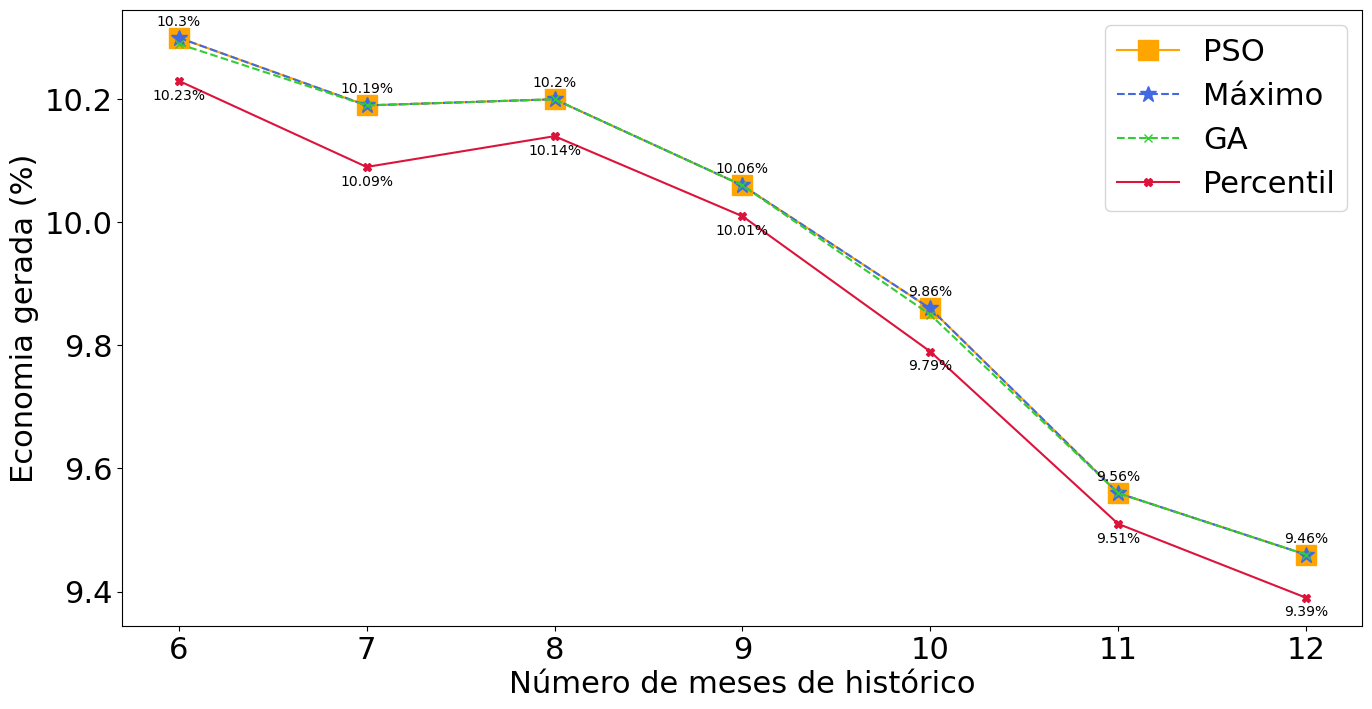

In [40]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = (16, 8)

economy_results = []
for r in results_per_range:
    economy_results.append(get_methods_economy_percentage(r))

percentile, pso, ga, potential = [], [], [], []
for r in economy_results:
    percentile.append(r[0])
    pso.append(r[1])
    ga.append(r[2])
    potential.append(r[3])

x = range(6, 13)

colors = ['#4169E1', '#FFA500', '#32CD32', '#DC143C']

plt.plot(x, pso, 's-', label='PSO', markersize=14, color=colors[1])
plt.plot(x, potential, '*--', label='Máximo', markersize=12, color=colors[0])
plt.plot(x, ga, 'x--', label='GA', color=colors[2])
plt.plot(x, percentile, 'X-', label='Percentil', color=colors[3])

plt.xlabel('Número de meses de histórico')
plt.ylabel('Economia gerada (%)')
plt.legend()

for i in range(len(x)):
    plt.text(x[i], potential[i] + 0.02, f'{round(potential[i], 2)}%', ha='center', fontsize=10)
    plt.text(x[i], percentile[i] - 0.03, f'{round(percentile[i], 2)}%', ha='center', fontsize=10)

plt.savefig('economia.png')

In [11]:
times = {}
n = 6
for r in results_per_range:
    times.update({n:get_methods_time_perf(r)})
    n += 1

print('Médias de tempo de execução (segundos)\n')
for i in range (6, 13):
    print(f'\tUtilizando {i} meses de histórico')
    time = times[i]
    print(f"\t\tPercentil: {time[0]['Percentil']:.10f}")
    print(f"\t\tPSO:       {time[1]['PSO-it']:.2f}")
    print(f"\t\tGA:        {time[2]['GA-it']:.2f}")
    print(f"\t\tCompleto:  {time[3]['Completo']:.2f}\n")

Médias de tempo de execução (segundos)

	Utilizando 6 meses de histórico
		Percentil: 0.0000400048
		PSO:       0.20
		GA:        0.11
		Completo:  2.89

	Utilizando 7 meses de histórico
		Percentil: 0.0000420350
		PSO:       0.24
		GA:        0.12
		Completo:  4.30

	Utilizando 8 meses de histórico
		Percentil: 0.0000611140
		PSO:       0.35
		GA:        0.17
		Completo:  4.90

	Utilizando 9 meses de histórico
		Percentil: 0.0000573763
		PSO:       0.37
		GA:        0.18
		Completo:  5.11

	Utilizando 10 meses de histórico
		Percentil: 0.0000505319
		PSO:       0.32
		GA:        0.16
		Completo:  5.17

	Utilizando 11 meses de histórico
		Percentil: 0.0000480560
		PSO:       0.34
		GA:        0.15
		Completo:  5.80

	Utilizando 12 meses de histórico
		Percentil: 0.0000519881
		PSO:       0.38
		GA:        0.18
		Completo:  6.06



In [38]:
n = 6
for r in results_per_range:
    ret = get_demand_diference(r)

    print(f'\n\tUtilizando {n} meses de histórico')
    print(f"\tPSO:\n\t\tPonta:      {ret['pso'][0]:.2f}\n\t\tFora Ponta: {ret['pso'][1]:.2f}\n\t\tUnica:      {ret['pso'][2]:.2f}")
    print(f"\tGA:\n\t\tPonta:      {ret['ga'][0]:.2f}\n\t\tFora Ponta: {ret['pso'][1]:.2f}\n\t\tUnica:      {ret['pso'][2]:.2f}")
    print(f"\tFlags:\n\t\t1 = {ret['flags'][0]}\n\t\t2 = {ret['flags'][1]}\n\t\t3 = {ret['flags'][2]}")
    n += 1


	Utilizando 6 meses de histórico
	PSO:
		Ponta:      3.50
		Fora Ponta: 6.17
		Unica:      16.20
	GA:
		Ponta:      3.50
		Fora Ponta: 6.17
		Unica:      16.20
	Flags:
		1 = 0
		2 = 0
		3 = 0

	Utilizando 7 meses de histórico
	PSO:
		Ponta:      -1.50
		Fora Ponta: -1.50
		Unica:      -2.55
	GA:
		Ponta:      -1.60
		Fora Ponta: -1.50
		Unica:      -2.55
	Flags:
		1 = 0
		2 = 0
		3 = 0

	Utilizando 8 meses de histórico
	PSO:
		Ponta:      1.33
		Fora Ponta: 0.50
		Unica:      2.25
	GA:
		Ponta:      1.17
		Fora Ponta: 0.50
		Unica:      2.25
	Flags:
		1 = 1
		2 = 1
		3 = 0

	Utilizando 9 meses de histórico
	PSO:
		Ponta:      6.69
		Fora Ponta: 4.38
		Unica:      11.04
	GA:
		Ponta:      6.69
		Fora Ponta: 4.38
		Unica:      11.04
	Flags:
		1 = 0
		2 = 0
		3 = 0

	Utilizando 10 meses de histórico
	PSO:
		Ponta:      -3.07
		Fora Ponta: -7.50
		Unica:      -4.33
	GA:
		Ponta:      -3.07
		Fora Ponta: -7.50
		Unica:      -4.33
	Flags:
		1 = 1
		2 = 1
		3 = 0

	Utilizando 11 meses de his

In [10]:
def get_methods_economy_mean(results):
    costs = pd.DataFrame(columns=results['../sheets-plus/UFMS.xlsx - 109001794-8'].method)
    for r in results:
        result = results[r].drop(columns=['method', 'flag', 'peak', 'off_peak', 'unique', 'num_months', 'time'])
        costs.loc[len(costs)] = result.T.values[0]

    pso_economy = round((costs.Percentil - costs['PSO-it']).sum()/len(results), 2)
    ga_economy = round((costs.Percentil - costs['GA-it']).sum()/len(results), 2)

    return pso_economy, ga_economy

In [11]:
for r in results_per_range:
    print("Medias para 6 meses")
    pso, ga = get_methods_economy_mean(r)
    print(f"\tpso: {pso}, ga: {ga}\n")

Medias para 6 meses
	pso: 38.43, ga: 39.37

Medias para 6 meses
	pso: 126.9, ga: 125.97

Medias para 6 meses
	pso: 107.48, ga: 106.99

Medias para 6 meses
	pso: 48.17, ga: 48.15

Medias para 6 meses
	pso: 165.43, ga: 162.87

Medias para 6 meses
	pso: 203.2, ga: 202.83

Medias para 6 meses
	pso: 295.61, ga: 293.57

